In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from utils.customloader import CustomDataset, DatasetSplit
from utils.separate_into_classes import separate_into_classes
#from utils.arguments import Args
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar
from models.Fed import FedAvg
from models.test import test_img
from utils.smooth_crossentropy import SmoothCrossEntropyLoss
from utils.dataloader import get_dataloader, set_seed
from utils.train_glob import train_global_model, test_model
import random
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import copy
from sklearn.model_selection import train_test_split



import torch
class Args:
    #federated arugments
    epochs=5
    num_users=10
    local_ep=1
    local_bs=10
    bs=128
    lr=0.01
    momentum=0.5
    split='user'
    
    
    #model arguments
    model='mnist'
    kernel_num=9
    kernel_sizes='3,4,5'
    norm='batch_norm'
    num_filters=32
    max_pool=True
    
    #other arguments
    #data='mnist'
    #iid='store_true'
    num_channels=1
    num_classes=10
    #stopping_rounds=10
    verbose='store_true'
    seed=1
    #all_clients='store_true'
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device('cpu')
    
    

args = Args()    
##############SET SEEDS FOR REPRODUCIBILITY#############
np.random.seed(args.seed)
random.seed(args.seed)
torch.manual_seed(args.seed)
# if you are suing GPU
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)


torch.backends.cudnn.enabled = False 
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True    
##############~SET SEEDS FOR REPRODUCIBILITY#############

In [2]:
global_train_loader, local_train_loader, test_loader = get_dataloader(data='mnist', 
                                                                      test_size=0.5, 
                                                                      num_workers=2,
                                                                      batch_size=128, 
                                                                      seed=args.seed,
                                                                     )

net_glob = CNNMnist(args=args).to(args.device)
net_glob.train()

optimizer = optim.SGD(net_glob.parameters(), lr=args.lr, momentum=args.momentum)
sloss = F.cross_entropy













(30000, 1, 28, 28)
torch.Size([30000])
(30000, 1, 28, 28)
torch.Size([30000])


(30000, 1, 28, 28)
(30000, 28, 28)


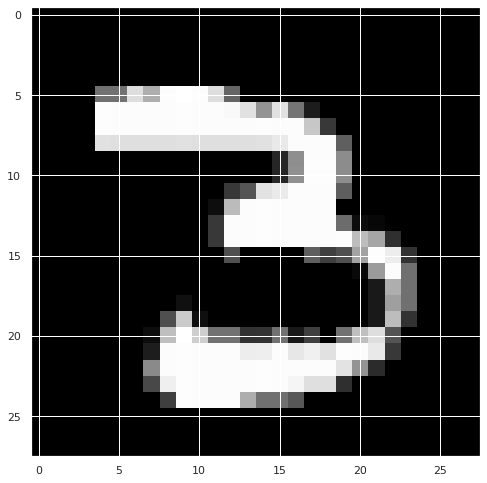

In [14]:
from sklearn.manifold import TSNE
import seaborn as sns
palette = sns.color_palette("bright", 10)
sns.set(rc={'figure.figsize':(11.7,8.27)})

data_train = global_train_loader.dataset.data
label_train = global_train_loader.dataset.targets

print(data_train.shape)
data_train = np.squeeze(np.transpose(data_train, (0, 2, 3, 1)))
print(data_train.shape)
plt.imshow(data_train[0], cmap='gray')

In [8]:
#X, y = load_digits(return_X_y=True)

X, y = data_train, label_train

In [9]:
X=X[0:10000]
y=y[0:10000]

print(X.shape)
X = np.reshape(X, (X.shape[0], 28*28))
print(X.shape)

(10000, 28, 28)
(10000, 784)


In [10]:
tsne = TSNE(n_jobs=-1, verbose=2)
X_embedded = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 1.399s...
[t-SNE] Computed neighbors for 10000 samples in 40.537s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 436.794717
[t-SNE] Computed conditional probabilities in 1.745s
[t-SNE] Iteration 50: error = 97.6552505, gradient norm = 0.0008160 (50 iterations in 2.175s)
[t-SNE]

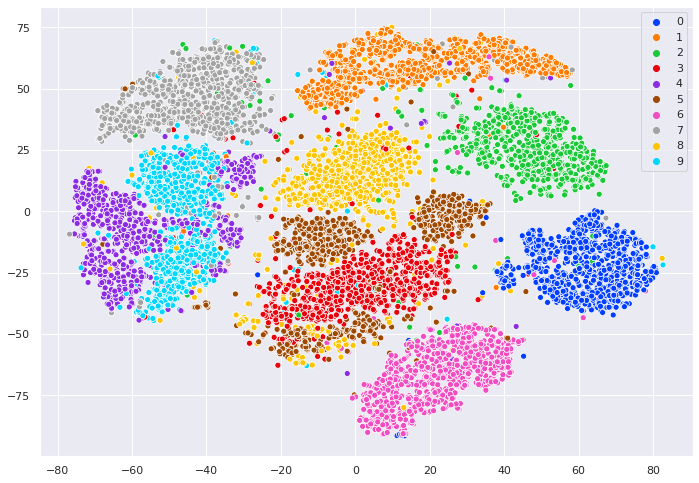

In [15]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)